

# Customer segmentation toolkit

> Data transformations toolkit made by Team #2 for the [MLOps Engineering Lab #2](https://github.com/mlopscommunity/engineering.labs/tree/master/Lab2_Feature_Store_for_ML) "Feature Store for ML".

- Documentation: https://artemlops.github.io/customer-segmentation-toolkit/

- Original notebook: [Customer segmentation](https://www.kaggle.com/fabiendaniel/customer-segmentation) by F. Daniel (September 2017) (saved to `data/customer-segmentation.ipynb`).
- Original dataset: [E-Commerce data: Actual transactions from UK retailer](https://www.kaggle.com/carrie1/ecommerce-data) (saved to `data/data.csv`).

- The work is done with the help of the [nbdev](https://nbdev.fast.ai/) tool, which allows you to develop a python library in Jupyter Notebooks, putting all your code, tests and documentation in one place.

## Installation

`pip install -U customer-segmentation-toolkit`

## Usage

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
from pathlib import Path

### 01. Load and split dataset

In [ ]:
#hide
%reset -f
import pandas as pd
from pathlib import Path

In [ ]:
import datetime
from customer_segmentation_toolkit.load_split import load_data_csv, split_by_invoice_date

ONLINEOFFLINE_DATE_SPLIT = datetime.date(2011,10,1)

# Loading original dataset
df = load_data_csv('../data/data.csv')
print(f'Loaded dataset, shape: {df.shape}')

# Splitting dataset to offline and online parts
df_offline, df_online = split_by_invoice_date(df, ONLINEOFFLINE_DATE_SPLIT)

print(f'Offline dataset shape: {df_offline.shape}')
print(f'Offline invoices: from {df_offline["InvoiceDate"].min()} to {df_offline["InvoiceDate"].max()}')

print(f'Online dataset shape: {df_online.shape}')
print(f'Online invoices: from {df_online["InvoiceDate"].min()} to {df_online["InvoiceDate"].max()}')

Loaded dataset, shape: (541909, 8)
Offline dataset shape: (370931, 8)
Offline invoices: from 2010-12-01 08:26:00 to 2011-09-30 17:22:00
Online dataset shape: (170978, 8)
Online invoices: from 2011-10-02 10:32:00 to 2011-12-09 12:50:00


In [ ]:
# Saving processed data
OUTPUT = Path(f'../data/output/01_data_split_offline_online')
OUTPUT.mkdir(exist_ok=True, parents=True)

df_offline.to_csv(f'{OUTPUT}/no_live_data.csv', index=False)
df_online.to_csv(f'{OUTPUT}/raw_live_data.csv', index=False)
Path(f'{OUTPUT}/onlineoffline_date_split.txt').write_text(str(ONLINEOFFLINE_DATE_SPLIT))

print(f'Output data saved to {OUTPUT}: {[p.name for p in Path(OUTPUT).iterdir()]}')

Output data saved to ../data/output/01_data_split_offline_online: ['onlineoffline_date_split.txt', 'no_live_data.csv', 'raw_live_data.csv']


### 02. Clean dataset rows

In [ ]:
#hide
%reset -f
import pandas as pd
from pathlib import Path

In [ ]:
from customer_segmentation_toolkit.load_split import load_data_csv
from customer_segmentation_toolkit.clean_rows import clean_data_rows

# Loading raw offline dataset'
df = load_data_csv('../data/output/01_data_split_offline_online/no_live_data.csv')
print(f'Loaded raw offline dataset, shape: {df.shape}')

# Cleaning the dataset
df_cleaned = clean_data_rows(df)
print(f'Cleaned offline dataset shape: {df.shape}')

Loaded raw offline dataset, shape: (370931, 8)
Cleaned offline dataset shape: (370931, 8)


In [ ]:
# Saving processed data
OUTPUT = Path(f'../data/output/02_data_clean_rows')
OUTPUT.mkdir(exist_ok=True, parents=True)

df_cleaned.to_csv(f'{OUTPUT}/no_live_data__cleaned.csv', index=False)

print(f'Output data saved to {OUTPUT}: {[p.name for p in Path(OUTPUT).iterdir()]}')

Output data saved to ../data/output/02_data_clean_rows: ['no_live_data__cleaned.csv']


### 03. Analyse purchases

In [ ]:
#hide
%reset -f
import pandas as pd
from pathlib import Path

In [ ]:
import datetime
from customer_segmentation_toolkit.load_split import load_data_csv
from customer_segmentation_toolkit.analyse_purchases import build_product_list

N_PURCHASE_CLUSTERS = 5
TRAINTEST_DATE_SPLIT = datetime.date(2011,8,1)

# Loading cleaned dataset
df_cleaned = load_data_csv('../data/output/02_data_clean_rows/no_live_data__cleaned.csv')
print(f'Loaded cleaned offline dataset, shape: {df_cleaned.shape}')

list_products = build_product_list(df_cleaned)
print(f'Built list of products:')
print(pd.DataFrame(list_products).head())
print('...')

Loaded cleaned offline dataset, shape: (263815, 10)
Built list of products:
         0    1
0    heart  251
1  vintage  195
2      set  194
3      bag  158
4      box  147
...


In [ ]:
from customer_segmentation_toolkit.analyse_purchases import build_keywords_matrix

# Building keywords count matrix
THRESHOLD = [0, 1, 2, 3, 5, 10]
matrix = build_keywords_matrix(df_cleaned, list_products, THRESHOLD)
print(f'Built keywords count matrix (shape: {matrix.shape}):')
print(matrix.head())

Built keywords count matrix (shape: (3662, 188)):
   heart  vintage  set  bag  box  glass  christmas  design  candle  flower  \
0      1        0    0    0    0      0          0       0       0       0   
1      0        0    0    0    0      0          0       0       0       0   
2      1        0    0    0    0      0          0       0       0       0   
3      0        0    0    0    0      0          0       0       0       0   
4      1        0    0    0    0      0          0       0       0       0   

   ...  medium  hen  wallet  point  0<.<1  1<.<2  2<.<3  3<.<5  5<.<10  .>10  
0  ...       0    0       0      0      0      0      1      0       0     0  
1  ...       0    0       0      0      0      0      0      1       0     0  
2  ...       0    0       0      0      0      0      0      1       0     0  
3  ...       0    0       0      0      0      0      0      1       0     0  
4  ...       0    0       0      0      0      0      0      1       0     0  

[5 row

In [ ]:
from customer_segmentation_toolkit.analyse_purchases import compute_purchase_clusters

# Computing purchases clusters via Kmeans
clusters = compute_purchase_clusters(matrix, N_PURCHASE_CLUSTERS)
print(f'Built purchase clusters:')
print(pd.Series(clusters).value_counts())

Built purchase clusters:
1    1117
4     911
0     638
2     566
3     430
dtype: int64


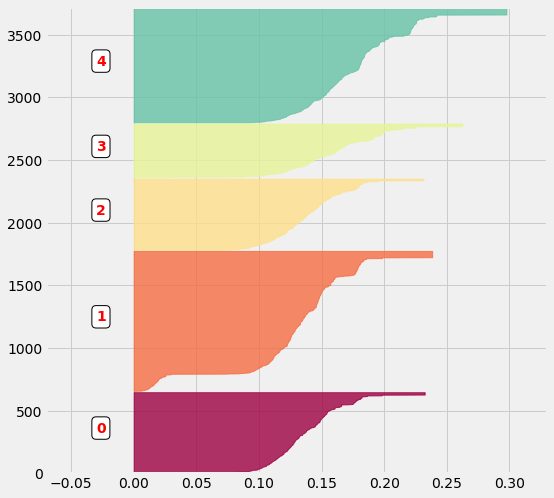

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from customer_segmentation_toolkit.analyse_purchases import plot_silhouette

silhouette_avg = silhouette_score(matrix, clusters)
sample_silhouette_values = silhouette_samples(matrix, clusters)
# Plotting silhouette values
plot_silhouette(N_PURCHASE_CLUSTERS, [-0.07, 0.33], len(matrix), sample_silhouette_values, clusters)

In [ ]:
from customer_segmentation_toolkit.analyse_purchases import add_purchase_clusters_info

# Constructing the result DataFrame
df_with_clusters = add_purchase_clusters_info(df_cleaned, clusters, N_PURCHASE_CLUSTERS)
print(f'Added purchase clusters info to the offline cleaned dataset:')
print(f'Shape: {df_with_clusters.shape}')
print(f'Columns: {list(df_with_clusters.columns)}')

Added purchase clusters info to the offline cleaned dataset:
Shape: (13081, 9)
Columns: ['CustomerID', 'InvoiceNo', 'Basket Price', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'InvoiceDate']


In [ ]:
from customer_segmentation_toolkit.load_split import split_by_invoice_date

# Splitting the new dataset (offline + cluster info) to train+test
df_offline_train, df_offline_test = split_by_invoice_date(df_with_clusters, TRAINTEST_DATE_SPLIT)
print(f'Splitted: train of shape {df_offline_train.shape} + test of shape {df_offline_test.shape}')

Splitted: train of shape (10054, 9) + test of shape (3027, 9)


In [ ]:
# Saving processed data

OUTPUT = Path(f'../data/output/03_data_compute_description_keywords')
OUTPUT.mkdir(exist_ok=True, parents=True)

matrix.to_csv(f'{OUTPUT}/no_live_data__cleaned__keywords.csv', index=False)
df_offline_train.to_csv(f'{OUTPUT}/no_live_data__cleaned__purchase_clusters__train.csv', index=False)
df_offline_test.to_csv(f'{OUTPUT}/no_live_data__cleaned__purchase_clusters__test.csv', index=False)

pd.DataFrame(THRESHOLD, columns=['threshold']).to_csv(f'{OUTPUT}/threshold.csv', index=False)

Path(f'{OUTPUT}/n_purchase_clusters.txt').write_text(str(N_PURCHASE_CLUSTERS))
Path(f'{OUTPUT}/traintest_date_split.txt').write_text(str(TRAINTEST_DATE_SPLIT))

print(f'Output data saved to {OUTPUT}: {[p.name for p in Path(OUTPUT).iterdir()]}')

Output data saved to ../data/output/03_data_compute_description_keywords: ['no_live_data__cleaned__keywords.csv', 'no_live_data__cleaned__purchase_clusters__test.csv', 'threshold.csv', 'n_purchase_clusters.txt', 'traintest_date_split.txt', 'no_live_data__cleaned__purchase_clusters__train.csv']


### 04. Analyse customer categories

In [ ]:
#hide
%reset -f
import pandas as pd
from pathlib import Path

In [ ]:
from customer_segmentation_toolkit.load_split import load_data_csv

N_CUSTOMER_CLUSTERS = 11
SELECTED_CUSTOMERS_CATEG_THRESHOLD = 40

# Loading cleaned offline train dataset
DATA = '../data/output/03_data_compute_description_keywords'
N_PURCHASE_CLUSTERS = int(Path(f'{DATA}/n_purchase_clusters.txt').read_text().strip())

basket_price = load_data_csv(f'{DATA}/no_live_data__cleaned__purchase_clusters__train.csv')
print(f'Loaded purchase clusters data of shape: {basket_price.shape}')
print(basket_price.head())
print('...')

Loaded purchase clusters data of shape: (10054, 9)
  CustomerID  InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
0      12347     537626        711.79    83.40   187.20   293.35   124.44   
1      12347     542237        475.39    53.10   168.75   169.20     0.00   
2      12347     549222        636.25    71.10   369.15   115.00     0.00   
3      12347     556201        382.52    78.06    74.40   168.76    19.90   
4      12348     539318        892.80     0.00   414.00     0.00     0.00   

   categ_4                   InvoiceDate  
0    23.40 2010-12-07 14:57:00.000001024  
1    84.34 2011-01-26 14:29:59.999999744  
2    81.00 2011-04-07 10:42:59.999999232  
3    41.40 2011-06-09 13:01:00.000000256  
4   478.80 2010-12-16 19:09:00.000000000  
...


In [ ]:
from customer_segmentation_toolkit.analyse_customers import build_transactions_per_user

# Building transactions per user
transactions_per_user = build_transactions_per_user(basket_price, n_purchase_clusters=N_PURCHASE_CLUSTERS)
print(f'Built transactions per user, shape: {transactions_per_user.shape}')
print(transactions_per_user.head())
print('...')

Built transactions per user, shape: (3143, 13)
  CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      4  382.52  711.79  551.487500  2205.95  12.949523   
1      12348      3  227.44  892.80  495.746667  1487.24   0.000000   
2      12350      1  334.40  334.40  334.400000   334.40  27.900718   
3      12352      4  144.35  840.30  360.370000  1441.48   3.683714   
4      12353      1   89.00   89.00   89.000000    89.00  19.887640   

     categ_1    categ_2    categ_3    categ_4  LastPurchase  FirstPurchase  
0  36.242889  33.831682   6.543213  10.432693            52            236  
1  54.059869   0.000000   0.000000  45.940131           117            227  
2  60.406699   0.000000   0.000000  11.692584           179            179  
3  77.977495   5.771846  11.859339   0.707606           131            165  
4  13.033708   0.000000  67.078652   0.000000            73             73  
...


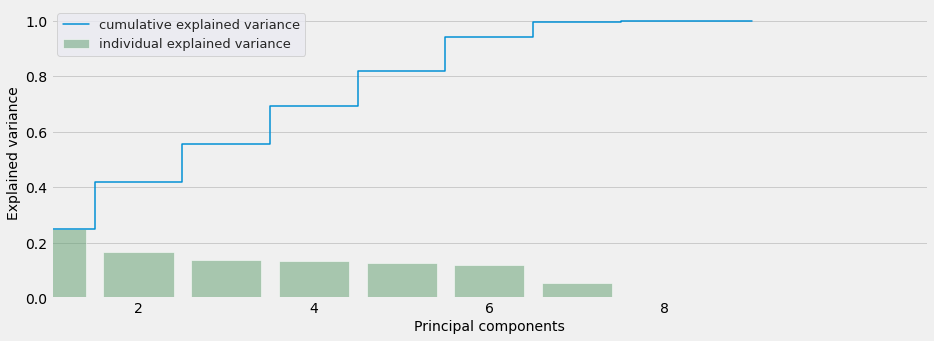

In [ ]:
from customer_segmentation_toolkit.analyse_customers import (
    plot_customers_pca,
    convert_customers_df_to_np,
    analyse_customers_pca,
)

# Analysing customers distribution via PCA
matrix = convert_customers_df_to_np(transactions_per_user, N_PURCHASE_CLUSTERS)
scaled_matrix, pca = analyse_customers_pca(matrix)

plot_customers_pca(matrix, pca)

In [ ]:
from customer_segmentation_toolkit.analyse_customers import compute_customer_clusters

# Computing customers clusters via Kmeans
clusters_clients = compute_customer_clusters(scaled_matrix, N_CUSTOMER_CLUSTERS)
print('Computed customers clusters via Kmeans:')
display(pd.Series(clusters_clients).value_counts())

Computed customers clusters via Kmeans:


7     1186
6      475
0      305
3      276
8      239
9      235
1      226
4      152
2       32
5       10
10       7
dtype: int64

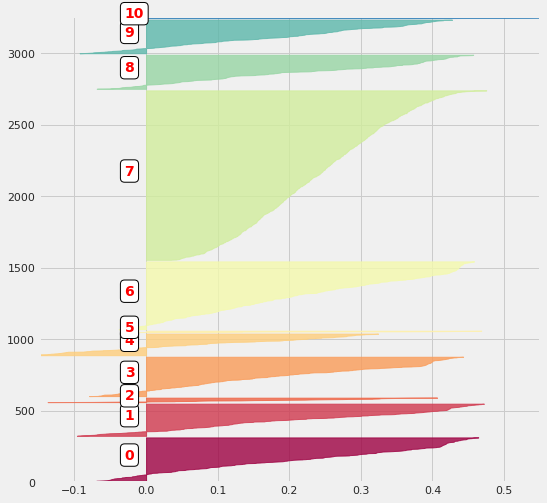

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from customer_segmentation_toolkit.analyse_purchases import plot_silhouette

silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

# Plotting silhouette values
plot_silhouette(N_CUSTOMER_CLUSTERS, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

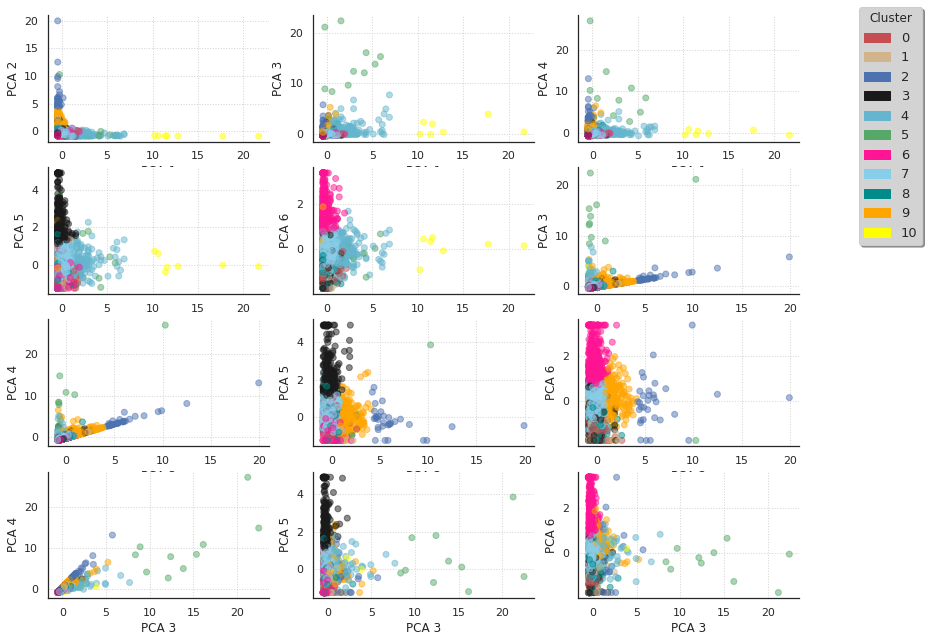

In [ ]:
from customer_segmentation_toolkit.analyse_customers import plot_customer_categories

# Plotting customers categories
plot_customer_categories(scaled_matrix, clusters_clients, N_CUSTOMER_CLUSTERS)

In [ ]:
from customer_segmentation_toolkit.analyse_customers import add_customer_clusters_info

# Constructing the result dataset
merged_df = add_customer_clusters_info(transactions_per_user, clusters_clients)
print(f'Constructed the result dataset:')
print(f'Shape: {merged_df.shape}')
print(f'Columns: {list(merged_df.columns)}')

Constructed the result dataset:
Shape: (3143, 14)
Columns: ['CustomerID', 'count', 'min', 'max', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'LastPurchase', 'FirstPurchase', 'cluster']


In [ ]:
from customer_segmentation_toolkit.analyse_customers import compute_aggregated_customer_clusters_info

# Constructing the aggregated cluster info dataset
selected_customers_df = compute_aggregated_customer_clusters_info(merged_df, N_PURCHASE_CLUSTERS, N_CUSTOMER_CLUSTERS,
                                                                  categ_threshold=SELECTED_CUSTOMERS_CATEG_THRESHOLD)
print('Constructed the aggregated cluster info:')
print(f'Shape: {selected_customers_df.shape}')
print(f'Columns: {list(selected_customers_df.columns)}')

Constructed the aggregated cluster info:
Shape: (11, 14)
Columns: ['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'LastPurchase', 'FirstPurchase', 'size']


In [ ]:
# Saving processed data
OUTPUT = Path(f'../data/output/04_data_analyse_customers')
OUTPUT.mkdir(exist_ok=True, parents=True)

selected_customers_df.to_csv(f'{OUTPUT}/no_live_data__cleaned__purchase_clusters__train__selected_customers_aggregated.csv', index=False)
merged_df.to_csv(f'{OUTPUT}/no_live_data__cleaned__purchase_clusters__train__customer_clusters.csv', index=False)

Path(f'{OUTPUT}/n_customer_clusters.txt').write_text(str(N_CUSTOMER_CLUSTERS))

print(f'Output data saved to {OUTPUT}: {[p.name for p in Path(OUTPUT).iterdir()]}')

Output data saved to ../data/output/04_data_analyse_customers: ['n_customer_clusters.txt', 'no_live_data__cleaned__purchase_clusters__train__selected_customers_aggregated.csv', 'no_live_data__cleaned__purchase_clusters__train__customer_clusters.csv']


---

### 05. Download dataset and use it for training

In [ ]:
#hide
%reset -f

import pandas as pd
from pathlib import Path

In [ ]:
from customer_segmentation_toolkit.data_zoo import download_data_csv
from sklearn.model_selection import train_test_split

# Download dataset from the data_zoo:
csv = 'no_live_data__cleaned__purchase_clusters__train__customer_clusters.csv'
selected_customers: pd.DataFrame = download_data_csv(f'data/output/04_data_analyse_customers/{csv}')

X = selected_customers[['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]]
Y = selected_customers['cluster']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2514, 6), (629, 6), (2514,), (629,))